See for more details: http://scikit-learn.org/stable/modules/clustering.html#k-means

**Generating Samples**

We are going to start by generating three centroids, and then randomly choose (with a normal distribution) around that point. First up, here is a method for doing this:

In [3]:
import tensorflow as tf
import numpy as np


def create_samples(n_clusters, n_samples_per_cluster, n_features, embiggen_factor, seed):
    np.random.seed(seed)
    slices = []
    centroids = []
    # Create samples for each cluster
    for i in range(n_clusters):
        samples = tf.random_normal((n_samples_per_cluster, n_features),
                                   mean=0.0, stddev=5.0, dtype=tf.float32, seed=seed, name="cluster_{}".format(i))
        current_centroid = (np.random.random((1, n_features)) * embiggen_factor) - (embiggen_factor/2)
        centroids.append(current_centroid)
        samples += current_centroid
        slices.append(samples)
    # Create a big "samples" dataset
    samples = tf.concat(slices, 0, name='samples')
    centroids = tf.concat(centroids, 0, name='centroids')
    return centroids, samples

In [4]:
n_features = 2
n_clusters = 3
n_samples_per_cluster = 500
seed = 700
embiggen_factor = 70

np.random.seed(seed)

centroids, samples = create_samples(n_clusters, n_samples_per_cluster, n_features, embiggen_factor, seed)

model = tf.global_variables_initializer()
with tf.Session() as session:
    # A Session object encapsulates the environment in which Operation objects are executed, 
    # and Tensor objects are evaluated.
    sample_values = session.run(samples)
    centroid_values = session.run(centroids)

All this code does is plots out the samples from each cluster using a different colour, and creates a big magenta X where the centroid is. The centroid is given as an argument, which will be handy later on.

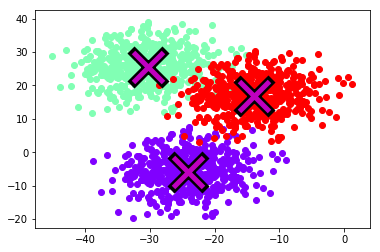

In [5]:
def plot_clusters(all_samples, centroids, n_samples_per_cluster):
    import matplotlib.pyplot as plt
    #Plot out the different clusters
    #Choose a different colour for each cluster
    colour = plt.cm.rainbow(np.linspace(0,1,len(centroids)))
    for i, centroid in enumerate(centroids):
         #Grab just the samples fpr the given cluster and plot them out with a new colour
         samples = all_samples[i*n_samples_per_cluster:(i+1)*n_samples_per_cluster]
         plt.scatter(samples[:,0], samples[:,1], c=colour[i])
         #Also plot centroid
         plt.plot(centroid[0], centroid[1], markersize=35, marker="x", color='k', mew=10)
         plt.plot(centroid[0], centroid[1], markersize=30, marker="x", color='m', mew=5)
    plt.show()

plot_clusters(sample_values, centroid_values, n_samples_per_cluster)

**Initialisation**

The k-means algorithm starts with the choice of the initial centroids, which are just random guesses of the actual centroids in the data. The following function will randomly choose a number of samples from the dataset to act as this initial guess.

This code first creates an index for each sample (using tf.range(0, n_samples), and then randomly shuffles it. From there, we choose a fixed number (n_clusters) of indices using tf.slice. These indices correlated to our initial centroids, which are then grouped together using tf.gather to form our array of initial centroids.

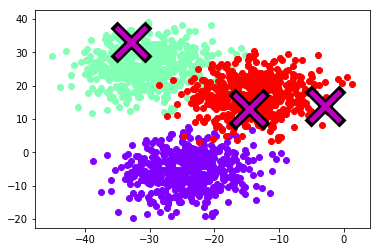

In [6]:
def choose_random_centroids(samples, n_clusters):
    # Step 0: Initialisation: Select `n_clusters` number of random points
    # Returns the shape of a tensor.
    # https://www.tensorflow.org/api_docs/python/tf/shape
    n_samples = tf.shape(samples)[0]
    # Randomly shuffles a tensor along its first dimension.
    random_indices = tf.random_shuffle(tf.range(0, n_samples))
    begin = [0,]
    size = [n_clusters,]
    size[0] = n_clusters
    # Extracts a slice from a tensor.
    centroid_indices = tf.slice(random_indices, begin, size)
    # Gather slices from params according to indices.
    # https://www.tensorflow.org/api_docs/python/tf/gather
    initial_centroids = tf.gather(samples, centroid_indices)
    return initial_centroids

n_features = 2
n_clusters = 3
n_samples_per_cluster = 500
seed = 700
embiggen_factor = 70

centroids, samples = create_samples(n_clusters, n_samples_per_cluster, n_features, embiggen_factor, seed)
initial_centroids = choose_random_centroids(samples, n_clusters)

model = tf.global_variables_initializer()
with tf.Session() as session:
    sample_values = session.run(samples)
    updated_centroid_value = session.run(initial_centroids)

plot_clusters(sample_values, updated_centroid_value, n_samples_per_cluster)

**Updating Centroids**

After starting with some guess for the centroid locations, the k-means algorithm then updates those guesses based on the data. The process is to assign each sample a cluster number, representing the centroid it is closest to. After that, the centroids are updated to be the means of all samples assigned to that cluster. The following code handles the assign to nearest cluster step:

In [7]:
def assign_to_nearest(samples, centroids):
    # Finds the nearest centroid for each sample

    # See: https://gist.github.com/narphorium/d06b7ed234287e319f18
    # Inserts a dimension of 1 into a tensor's shape.
    # https://www.tensorflow.org/api_docs/python/tf/expand_dims
    # We extend both of our 2D tensors into 3 dimensions so that we can 
    # do an element-wise subtraction between them.
    # Inserts a dimension of 1 into a tensor's shape.
    # https://www.tensorflow.org/api_docs/python/tf/expand_dims
    expanded_vectors = tf.expand_dims(samples, 0)
    expanded_centroids = tf.expand_dims(centroids, 1)
    # Computes the sum of elements across dimensions of a tensor.
    # https://www.tensorflow.org/api_docs/python/tf/reduce_sum
    distances = tf.reduce_sum( tf.square(
               tf.subtract(expanded_vectors, expanded_centroids)), 2)
    # Returns the index with the smallest value across axes of a tensor.
    # https://www.tensorflow.org/api_docs/python/tf/argmin
    mins = tf.argmin(distances, 0)
    nearest_indices = mins
    return nearest_indices

The way this works is to compute the distance between each sample and each centroid, which occurs through the distances = line. The distance computation here is the Euclidean distance. An important point here is that tf.subtract will automatically expand the size of the two arguments. This means that having our samples as a matrix, and the centroids as a column vector will produce the pairwise subtraction between them. In order to do this, we use tf.expand_dims to create an extra dimension for both samples and centroids, forcing this behaviour of tf.subtract.

In [8]:
def update_centroids(samples, nearest_indices, n_clusters):
    # Updates the centroid to be the mean of all samples associated with it.
    nearest_indices = tf.to_int32(nearest_indices)
    # Partitions data into num_partitions tensors using indices from partitions.
    # https://www.tensorflow.org/api_docs/python/tf/dynamic_partition
    partitions = tf.dynamic_partition(samples, nearest_indices, n_clusters)
    # Computes the mean of elements across dimensions of a tensor.
    # https://www.tensorflow.org/api_docs/python/tf/reduce_mean
    new_centroids = tf.concat([tf.expand_dims(tf.reduce_mean(partition, 0), 0) for partition in partitions], 0)
    return new_centroids

This code takes the nearest indices for each sample, and grabs those out as separate groups using tf.dynamic_partition. From here, we use tf.reduce_mean on a single group to find the average of that group, forming its new centroid. From here, we just tf.concat them together to form our new centroids.

Now we have the piece in place, we can add these calls to our script (or create a new one).

This code will:

* Generate samples from initial centroids
* Randomly choose initial centroids
* Associate each sample to its nearest centroid
* Update each centroid to be the mean of the samples associated to it

[[-17.709795    22.63220215]
 [-29.10573387  13.23136711]
 [-14.61905575   5.69967842]]


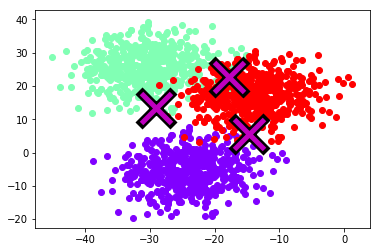

In [9]:
n_features = 2
n_clusters = 3
n_samples_per_cluster = 500
seed = 700
embiggen_factor = 70


data_centroids, samples = create_samples(n_clusters, n_samples_per_cluster, n_features, embiggen_factor, seed)
initial_centroids = choose_random_centroids(samples, n_clusters)
nearest_indices = assign_to_nearest(samples, initial_centroids)
updated_centroids = update_centroids(samples, nearest_indices, n_clusters)

model = tf.global_variables_initializer()
with tf.Session() as session:
    sample_values = session.run(samples)
    updated_centroid_value = session.run(updated_centroids)
    print(updated_centroid_value)

plot_clusters(sample_values, updated_centroid_value, n_samples_per_cluster)

[<tf.Tensor 'Mean_15:0' shape=(1, 2) dtype=float64>, <tf.Tensor 'Mean_16:0' shape=(1, 2) dtype=float64>, <tf.Tensor 'Mean_17:0' shape=(1, 2) dtype=float64>]
Instructions for updating:
Use `tf.global_variables_initializer` instead.
centroids
[[ 5.49764219  1.88174047]
 [ 2.47622926  6.16805393]
 [ 7.7055936   7.19902757]]


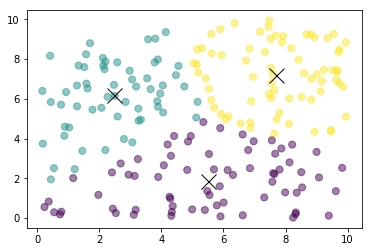

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

points_n = 200
clusters_n = 3
iteration_n = 100

points = tf.constant(np.random.uniform(0, 10, (points_n, 2)))
centroids = tf.Variable(tf.slice(tf.random_shuffle(points), [0, 0], [clusters_n, -1]))

points_expanded = tf.expand_dims(points, 0)
centroids_expanded = tf.expand_dims(centroids, 1)

distances = tf.reduce_sum(tf.square(tf.subtract(points_expanded, centroids_expanded)), 2)
assignments = tf.argmin(distances, 0)

means = []
for c in xrange(clusters_n):
    means.append(tf.reduce_mean(
      tf.gather(points, 
                tf.reshape(
                  # Return the elements, either from x or y, depending on the condition.
                  # https://www.tensorflow.org/api_docs/python/tf/where
                  tf.where(
                    tf.equal(assignments, c)
                  ),[1,-1])
               ),reduction_indices=[1]))

print means
new_centroids = tf.concat(means, 0)

update_centroids = tf.assign(centroids, new_centroids)
init = tf.initialize_all_variables()

with tf.Session() as sess:
  sess.run(init)
  for step in xrange(iteration_n):
    [_, centroid_values, points_values, assignment_values] = sess.run([update_centroids, centroids, points, assignments])
    
  print "centroids" + "\n", centroid_values

plt.scatter(points_values[:, 0], points_values[:, 1], c=assignment_values, s=50, alpha=0.5)
plt.plot(centroid_values[:, 0], centroid_values[:, 1], 'kx', markersize=15)
plt.show()

The tutorial from: http://learningtensorflow.com/lesson6/